Imports
-

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from os import listdir
from torch.utils.tensorboard import SummaryWriter

from torchvision import models
from torchsummary import summary

import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math

Device bestimmen
-

In [2]:
import gc

gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('This Conputation is running on {}'.format(device))

This Conputation is running on cpu


Bilder importieren
-

In [3]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
])

batchSize = 64

#Bilder aus dem verzeichnis in einen Tensor schreiben
true_images_list = []
for f in listdir('C:/Users/meldr/PythonProjects/GAN-Bilder/Anime/'):
    # f ist gleich der Dateiname
    img = Image.open("C:/Users/meldr/PythonProjects/GAN-Bilder/Anime/" + f)
    img_tensor = transforms(img) 
    true_images_list.append(img_tensor)
train_data = torch.stack(true_images_list) #Liste mit Image-Tensoren

#DataLoader für echte Bilder
trueloader = torch.utils.data.DataLoader(train_data, batch_size=batchSize, shuffle=True, num_workers=3) #pin_memory=True -> GPU

Generator konstruieren
-

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__() #Superkonstruktor für das NN
        self.generate = nn.Sequential(
            nn.ConvTranspose2d(3, 512, 6, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh() 
        )
        
    def forward(self,x):
        generated = self.generate(x)
        return generated
    


In [5]:
#Zusammenfassung vom Generator zur Überprüfung der Layer
gen_sum = Generator().to(device)
summary(gen_sum, (3, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           55,808
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,408
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,416
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,136
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32] 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           55,808
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,408
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,416
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,136
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32] 

Discriminator konstruieren
-

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__() #Superkonstruktor für das NN
        self.discriminate = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),  
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 3, 4, stride=3, padding=1),
            nn.Sigmoid() 
        )
        
    def forward(self,x):
        discriminated = self.discriminate(x)
        return discriminated 


In [7]:
#Zusammenfassung vom Discriminator zur Überprüfung der Layer
disc_sum = Discriminator().to(device)
summary(disc_sum, (3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,136
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─LeakyReLU: 2-3                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 128, 16, 16]         131,200
|    └─BatchNorm2d: 2-5                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-6                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-7                       [-1, 256, 8, 8]           524,544
|    └─BatchNorm2d: 2-8                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-9                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-10                      [-1, 512, 4, 4]           2,097,664
|    └─BatchNorm2d: 2-11                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-12                   [-1, 512, 4, 4]   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,136
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─LeakyReLU: 2-3                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 128, 16, 16]         131,200
|    └─BatchNorm2d: 2-5                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-6                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-7                       [-1, 256, 8, 8]           524,544
|    └─BatchNorm2d: 2-8                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-9                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-10                      [-1, 512, 4, 4]           2,097,664
|    └─BatchNorm2d: 2-11                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-12                   [-1, 512, 4, 4]   

Instanziierung des Generators, Discriminators, Optimizer
-

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss().to(device)
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5,0.999))
discr_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))

Training des GANs
-

In [9]:
#1.Erstellung einer Random-Noise
fake_image = torch.rand(batchSize, 3, 1, 1, device=device)

for epoch in range(30):
    print(epoch + 1,'. Epoche gestartet.')
    #cuda-cache leeren
    gc.collect()
    torch.cuda.empty_cache()

    #Zähler für den Batch-Lauf
    batchID = 0

    #Training des GANs auf Basis der importierten Images
    for true_image in trueloader:         
        
        ####### Train Discriminator

        #D.1 Fake-Image generieren
        fake_generated = generator(fake_image).detach()
        #D.2 Gradienten des Discriminators zurücksetzen
        discr_optimizer.zero_grad()
        #D.3 Train Discriminator mit True-Images
        true_prediction = discriminator(true_image.to(device))#.view(-1)
        #D.4 Loss mit der true_prediction und den Target 11111... berechnen
        loss_discr_true = criterion(true_prediction, torch.ones_like(true_prediction, device=device))  
        #D.5 Train Discriminator mit generierten Fake-Images
        fake_prediction = discriminator(fake_generated)#.view(-1)
        #D.6 Loss mit der fake_prediction und den Target 00000... berechnen
        loss_discr_fake = criterion(fake_prediction, torch.zeros_like(fake_prediction, device=device))
        #D.7 Backpropagation auf Basis des Losses für die True-Prediction des Discriminators
        loss_discr_true.backward()
        #D.8 Backpropagation auf Basis des Losses für die Fake-Prediction des Discriminators
        loss_discr_fake.backward()
        #D.9 Gewichte des Discriminators mit dem Gradienten aktualisieren
        discr_optimizer.step()


        ########################################

        ###### Train Generator
        
        #G.1 Fake-Image generieren
        fake_generated = generator(fake_image)
        #G.2 Gradienten des Generators zurücksetzen
        gen_optimizer.zero_grad()
        #G.3 Discriminator mit den generierten Images trainieren, nachdem der Discriminator trainiert wurde
        gen_prediction = discriminator(fake_generated.to(device))#.view(-1)
        #D.5 Loss des Generators mit der gen_prediction und den Target 11111... berechnen
        loss_gen_pred = criterion(gen_prediction, torch.ones_like(gen_prediction, device=device))
        #D.6 Backpropagation auf Basis des Generator-Losses auf den Generator
        loss_gen_pred.backward()
        #D.7 Gewichte des Generators mit dem Gradienten aktualisieren
        gen_optimizer.step()
        
        #Printing des Losses für den ersten Batchlauf jeder Epoche 
        if batchID == 0:
                    print('Epoche', epoch + 1, ' / Bachtlauf:', batchID)
                    print('/ Loss Discriminator with Real-Images: ', loss_discr_true.item())
                    print('/ Loss Discriminator with Fake-Images: ', loss_discr_fake.item())
                    print('/ Loss Generator: ', loss_gen_pred.item())

        #Zähler für den Batchlauf erhöhen
        batchID += 1


    print('-Epoche', epoch + 1, 'beendet-')


1 . Epoche gestartet.
Epoche 1  / Bachtlauf: 0
/ Loss Discriminator with Real-Images:  0.6272611021995544
/ Loss Discriminator with Fake-Images:  0.7553158402442932
/ Loss Generator:  3.8972558975219727
-Epoche 1 beendet-
2 . Epoche gestartet.
Epoche 2  / Bachtlauf: 0
/ Loss Discriminator with Real-Images:  0.2906908690929413
/ Loss Discriminator with Fake-Images:  0.45468902587890625
/ Loss Generator:  4.564342021942139
-Epoche 2 beendet-
3 . Epoche gestartet.
Epoche 3  / Bachtlauf: 0
/ Loss Discriminator with Real-Images:  0.1052367091178894
/ Loss Discriminator with Fake-Images:  0.24179697036743164
/ Loss Generator:  4.21795129776001
-Epoche 3 beendet-
4 . Epoche gestartet.
Epoche 4  / Bachtlauf: 0
/ Loss Discriminator with Real-Images:  0.40313419699668884
/ Loss Discriminator with Fake-Images:  0.1918599158525467
/ Loss Generator:  3.758190870285034
-Epoche 4 beendet-
5 . Epoche gestartet.
Epoche 5  / Bachtlauf: 0
/ Loss Discriminator with Real-Images:  0.2554336488246918
/ Loss 

Ausgabe eines einzelnen Bildes
-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


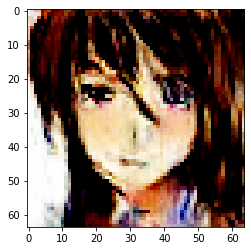

In [18]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



fake_plot = generator(torch.rand(batchSize, 3, 1, 1, device=device))

#Einzelnes Bild ausgeben
img = fake_plot[2].detach().numpy()
nimg = np.transpose(img, (1, 2, 0))
print(nimg.shape)
plt.imshow(nimg)
plt.show()


Ausgabe mehrerer Bilder
-

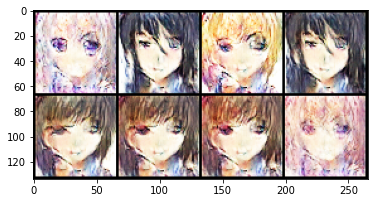

In [17]:
from torch.autograd import Variable
from torchvision.utils import make_grid

fake_grid = generator(torch.rand(8, 3, 1, 1, device=device))
grid = make_grid(fake_grid, nrow=4,
                 normalize=True).permute(1, 2, 0).numpy()
plt.imshow(grid)
plt.show()
